# Modeling: try boosting

## Import packages

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as sklearn_version
import datetime

import joblib
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

## Load X and y data sets

In [2]:
# import X and y training and test sets

X = pd.read_csv('../../data/train_test/X_alt')
y = pd.read_csv('../../data/train_test/y_alt')

X_train = pd.read_csv('../../data/train_test/X_train_74_26')

X_test = pd.read_csv('../../data/train_test/X_test_74_26')

y_train = pd.read_csv('../../data/train_test/y_train_alt_74_26')

y_test = pd.read_csv('../../data/train_test/y_test_alt+74_26')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

In [4]:
gb_pipe = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=42))])

In [5]:
gb_param_grid = {}

In [6]:
gb_grid = GridSearchCV(gb_pipe, gb_param_grid, cv=5)
gb_grid.fit(X_train, y_train)
gb_grid.best_score_, gb_grid.best_params_

(0.24435487648024434, {})

In [7]:
gb_param_grid = {'scaler':[None, StandardScaler()]}

In [8]:
gb_grid2 = GridSearchCV(gb_pipe, gb_param_grid, cv=5)
gb_grid2.fit(X_train, y_train)
gb_grid2.best_score_, gb_grid2.best_params_

(0.24442549221719467, {'scaler': None})

In [23]:
gb_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('gb', GradientBoostingRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'gb': GradientBoostingRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'ls',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_impurity_split': None,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__random_state': 42,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [12]:
feat_imp_1 = gb_grid.best_estimator_.named_steps.gb.feature_importances_
feat_imp_grid_1 = pd.Series(feat_imp_1, index=X_train.columns).sort_values(ascending=False)

feat_imp_2 = gb_grid2.best_estimator_.named_steps.gb.feature_importances_
feat_imp_grid_2 = pd.Series(feat_imp_2, index=X_train.columns).sort_values(ascending=False)

In [16]:
feat_imp_grid_1.head(20), feat_imp_grid_2.head(20)

(HAA_MALE_ratio_2017_2019_diff             0.160236
 HWA_MALE_ratio_2018                       0.079312
 HAA_MALE_ratio_2018_2019_diff             0.044170
 HWAC_MALE_ratio_2018                      0.038594
 HBAC_FEMALE_ratio_2017_2018_diff          0.037680
 HS_TOT_2017_2018_pct_change               0.032877
 IAC_FEMALE_ratio_2017_2018_pct_change     0.030825
 Employed_2018_2019_diff                   0.026168
 NHIA_FEMALE_ratio_2017_2018_pct_change    0.020995
 AQI_2017_2018_diff                        0.020929
 HWA_FEMALE_2018                           0.015607
 NHNAC_MALE_2017_2018_pct_change           0.015131
 HIA_FEMALE_ratio_2017_2019_diff           0.014355
 NH_FEMALE_ratio_2018                      0.013454
 NHAA_MALE_2017_2019_pct_change            0.012586
 NAC_FEMALE_2017_2019_pct_change           0.012515
 NHNAC_MALE_ratio_2017_2018_diff           0.012270
 BACH_TOT_2017_2019_diff                   0.011346
 NHBAC_FEMALE_ratio_2017_2018_diff         0.011313
 HIA_FEMALE_

it appears that feature importance for scaled and none scaled are about the same; even though scores differ slightly. Also it seems that the first 10 features explain much of our model

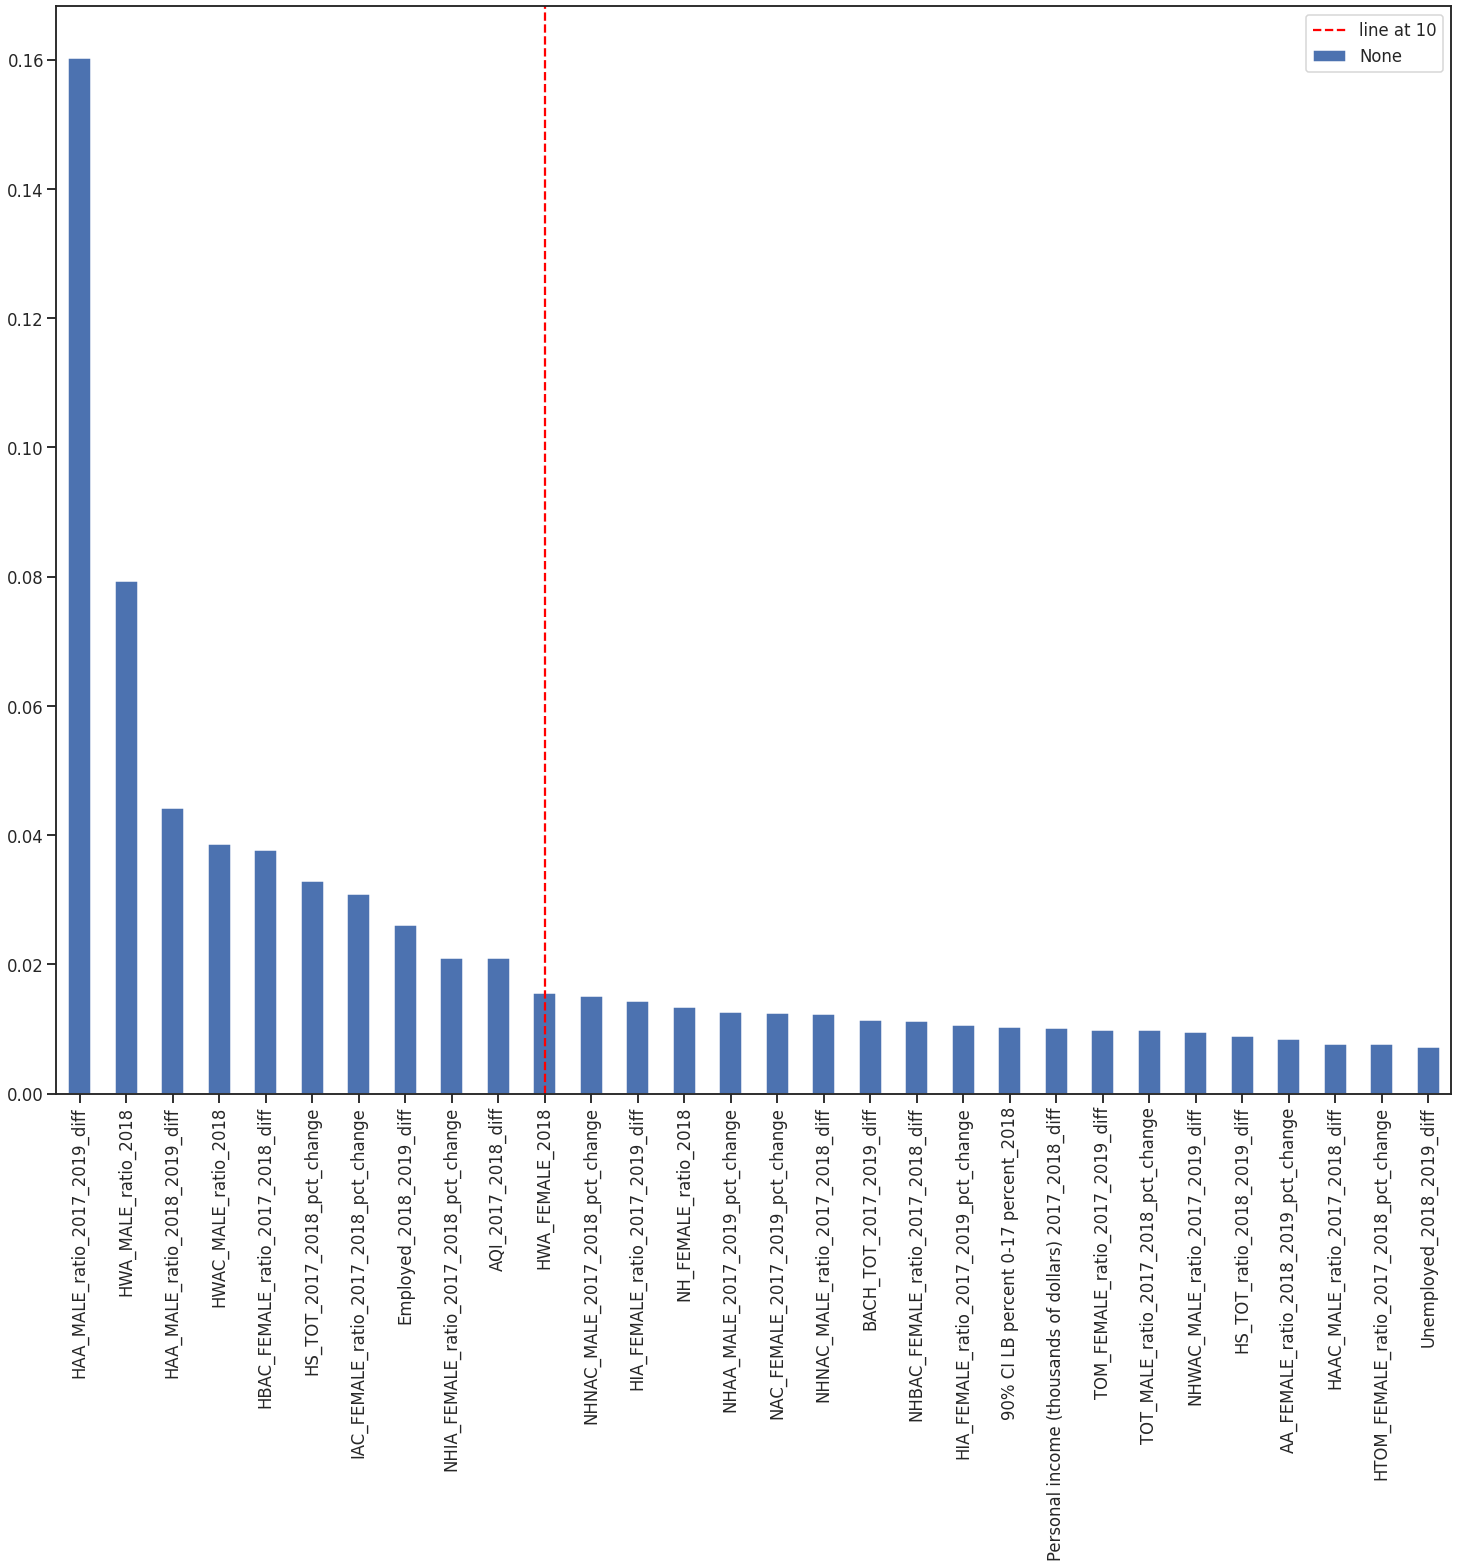

In [26]:
plt.figure(figsize=(25,20))
feat_imp_grid_1[:30].plot(kind='bar')
plt.axvline(x=10, label='line at 10', c='red', linestyle='--')
plt.legend()

# Try messing with gradient boosting with increment adding number of features

In [42]:
reduced_cols = feat_imp_grid_1[:20].index.tolist()
X_train_reduced = X_train[reduced_cols]
X_test_reduced = X_test[reduced_cols]
reduced_cols

['HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HAA_MALE_ratio_2018_2019_diff',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_2017_2018_pct_change',
 'IAC_FEMALE_ratio_2017_2018_pct_change',
 'Employed_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2018_pct_change',
 'AQI_2017_2018_diff',
 'HWA_FEMALE_2018',
 'NHNAC_MALE_2017_2018_pct_change',
 'HIA_FEMALE_ratio_2017_2019_diff',
 'NH_FEMALE_ratio_2018',
 'NHAA_MALE_2017_2019_pct_change',
 'NAC_FEMALE_2017_2019_pct_change',
 'NHNAC_MALE_ratio_2017_2018_diff',
 'BACH_TOT_2017_2019_diff',
 'NHBAC_FEMALE_ratio_2017_2018_diff',
 'HIA_FEMALE_ratio_2017_2019_pct_change']

In [43]:
gb_param_grid = {'scaler':[StandardScaler()]}

In [44]:
gb_grid3 = GridSearchCV(gb_pipe, gb_param_grid, cv=5)
gb_grid3.fit(X_train_reduced, y_train)
gb_grid3.best_score_, gb_grid3.best_params_

(0.40596085129148013, {'scaler': StandardScaler()})

Reducing features signifiacntly imporved train score


In [121]:
mean_score = []
test_score = []
for num in range(1, 100):
    reduced_cols = feat_imp_grid_1[:num].index.tolist()
    X_train_reduced = X_train[reduced_cols]
    X_test_reduced = X_test[reduced_cols]
    gb_grid_tmp = GridSearchCV(gb_pipe, gb_param_grid, cv=5)
    gb_grid_tmp.fit(X_train_reduced, y_train)
    mean_score.append(gb_grid_tmp.best_score_)
    test_score.append(gb_grid_tmp.score(X_test_reduced, y_test))



In [54]:
max_index = mean_score.index(max(mean_score)) + 1

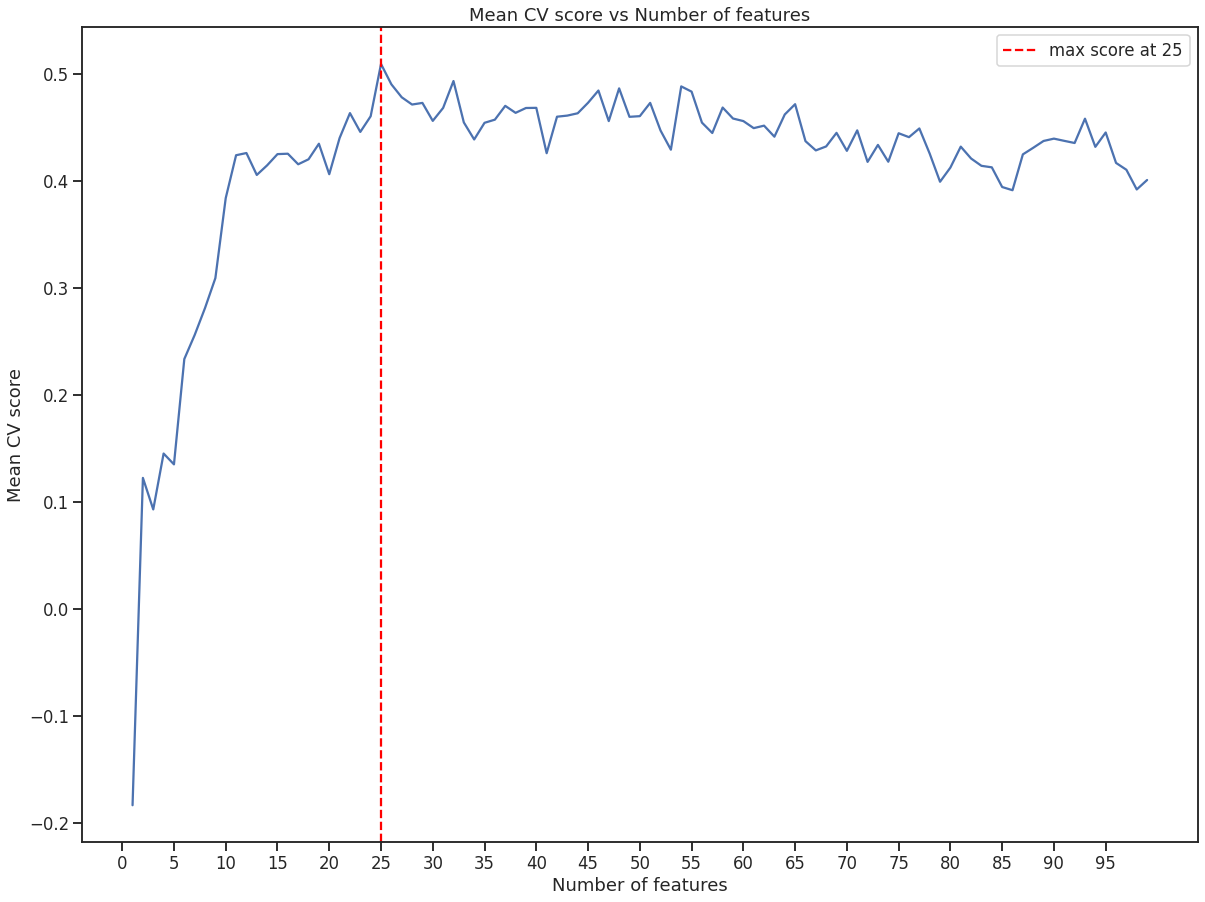

In [64]:
plt.figure(figsize=(20, 15))
sns.lineplot(x=np.arange(1, 100), y=mean_score)
plt.axvline(x=max_index, label='max score at {}'.format(max_index), color='red', linestyle='--')
plt.xticks(np.arange(0,100, 5))
plt.xlabel('Number of features')
plt.ylabel('Mean CV score')
plt.title('Mean CV score vs Number of features')
plt.legend();


Best number of features to have is 25 with a mean train score of .508
It also appears that after 10 features is where we see increase in mean scores; and number of features between 20 to 60
appear highest

In [129]:
reduced_cols = feat_imp_grid_1[:25].index.tolist()
X_train_reduced = X_train[reduced_cols]
X_test_reduced = X_test[reduced_cols]
reduced_cols

['HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HAA_MALE_ratio_2018_2019_diff',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_2017_2018_pct_change',
 'IAC_FEMALE_ratio_2017_2018_pct_change',
 'Employed_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2018_pct_change',
 'AQI_2017_2018_diff',
 'HWA_FEMALE_2018',
 'NHNAC_MALE_2017_2018_pct_change',
 'HIA_FEMALE_ratio_2017_2019_diff',
 'NH_FEMALE_ratio_2018',
 'NHAA_MALE_2017_2019_pct_change',
 'NAC_FEMALE_2017_2019_pct_change',
 'NHNAC_MALE_ratio_2017_2018_diff',
 'BACH_TOT_2017_2019_diff',
 'NHBAC_FEMALE_ratio_2017_2018_diff',
 'HIA_FEMALE_ratio_2017_2019_pct_change',
 '90% CI LB percent 0-17 percent_2018',
 'Personal income (thousands of dollars) 2017_2018_diff',
 'TOM_FEMALE_ratio_2017_2019_diff',
 'TOT_MALE_ratio_2017_2018_pct_change',
 'NHWAC_MALE_ratio_2017_2019_diff']

In [61]:
gb_param_grid = {'scaler':[StandardScaler()]}

In [62]:
gb_grid4 = GridSearchCV(gb_pipe, gb_param_grid, cv=5)
gb_grid4.fit(X_train_reduced, y_train)
gb_grid4.best_score_, gb_grid4.best_params_

(0.5089843286415915, {'scaler': StandardScaler()})

In [63]:
gb_grid4.score(X_test_reduced, y_test)

0.2607430199231512

Unfortunately like most gradient boosted models we get low bias but high variance; and it appears that we are overfitting as our train
significantly does twice as well as our test score

## perform hypertuning of gb model

In [66]:
gb_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('gb', GradientBoostingRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'gb': GradientBoostingRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'ls',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_impurity_split': None,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__random_state': 42,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [83]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

In [84]:
gb_param_grid5 = {
    'gb__n_estimators':n_est
}

In [85]:
gb_grid5 = GridSearchCV(gb_pipe, gb_param_grid5, cv=5)
gb_grid5.fit(X_train_reduced, y_train)
gb_grid5.best_score_, gb_grid5.best_params_

(0.5094376596831202, {'gb__n_estimators': 143})

In [86]:
gb_mean_score = gb_grid5.cv_results_['mean_test_score']
gb_std_score = gb_grid5.cv_results_['std_test_score']
num_est_values = [est for est in gb_grid5.cv_results_['param_gb__n_estimators']]

Text(0, 0.5, 'mean cv score')

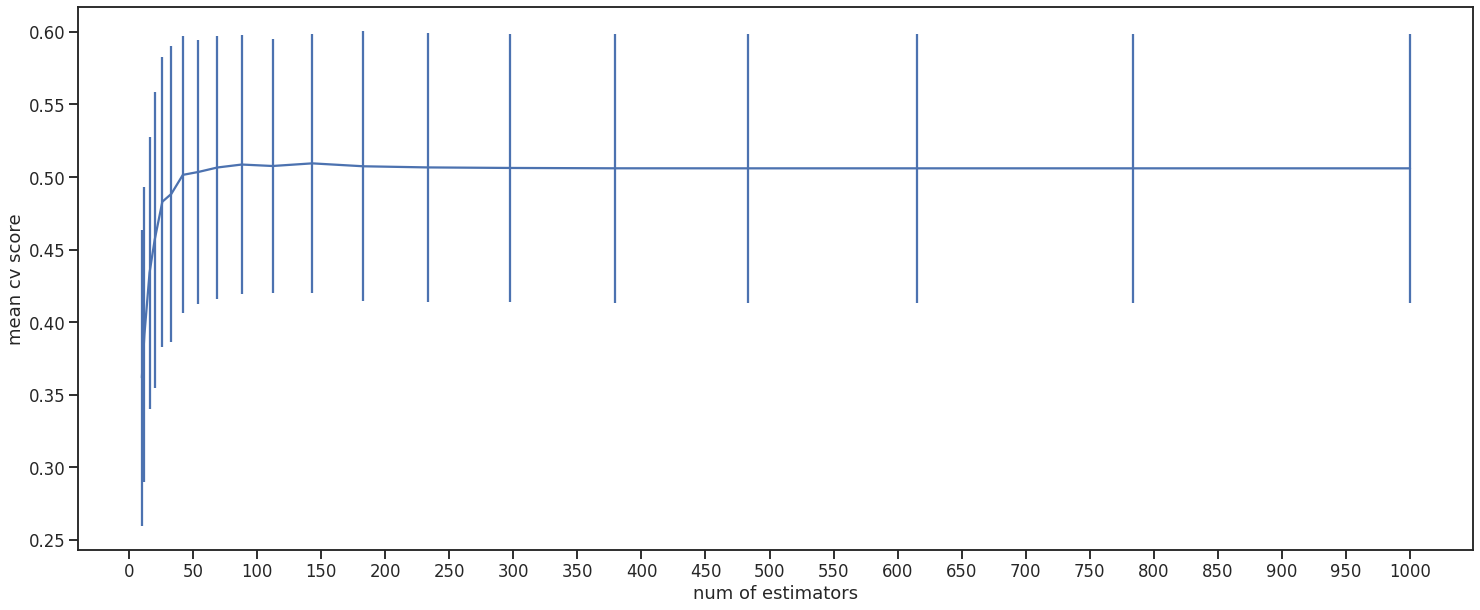

In [95]:
plt.figure(figsize=(25,10))
plt.errorbar(num_est_values, gb_mean_score, yerr=gb_std_score)
plt.xticks(np.arange(0,1050,50))
plt.xlabel('num of estimators')
plt.ylabel('mean cv score')

In [97]:
gb_grid5.score(X_test_reduced, y_test)

0.25891246942268176

It appears that it reaches its max around 50-200 estimators and then just stagnates improvment

Next step is to add learn rate and see changes with this parameter

In [116]:
n_est = [int(n) for n in np.logspace(start=2, stop=2.2, num=20)]

lrn_rate = np.logspace(start=-2, stop=-0.5, num=10)

In [117]:
gb_param_grid6 = {
    'gb__n_estimators':n_est,
    'gb__learning_rate':lrn_rate
}

In [118]:
gb_grid6 = GridSearchCV(gb_pipe, gb_param_grid6, cv=5)
gb_grid6.fit(X_train_reduced, y_train)
gb_grid6.best_score_, gb_grid6.best_params_

(0.5161550121157827,
 {'gb__learning_rate': 0.03162277660168379, 'gb__n_estimators': 154})

In [119]:
gb_grid6.score(X_test_reduced, y_test)

0.2627488802282605

try randomized grid with diff paramters

In [364]:
lrn_rate = np.arange(0.03, 0.05, step=.001)
gb_param_grid7 = {
    'gb__n_estimators':[150],
    # 'gb__n_estimators':np.arange(1,200),
    # 'gb__learning_rate':[0.0387],
    'gb__learning_rate':[0.0311],
    'gb__min_samples_leaf':[15],
    'gb__max_features':['log2'],
}


gb_grid7 = GridSearchCV(gb_pipe, gb_param_grid7, cv=5, n_jobs=-1)
# gb_grid7 = RandomizedSearchCV(gb_pipe, gb_param_grid7, cv=5, n_jobs=-1, random_state=42)
gb_grid7.fit(X_train_reduced, y_train)
display(gb_grid7.best_score_, gb_grid7.best_params_)

0.4428730838571699

{'gb__learning_rate': 0.0311,
 'gb__max_features': 'log2',
 'gb__min_samples_leaf': 15,
 'gb__n_estimators': 150}

Reduced Overfitting achieved by decreasing number of estimators
increase min_samples_leaf
change max featurs to log2

In [354]:
gb_grid7.score(X_test_reduced, y_test)

0.44283661866855917

In [365]:
best_gb = gb_grid7.best_estimator_

In [366]:
path = r'../../model/gb_model.sav'
joblib.dump(best_gb, path)

['../../model/gb_model.sav']

## Evaluation metrics and graph predict vs actual

In [5]:
path = r'../../model/gb_model.sav'
gb = joblib.load(path)

reduced_cols = ['HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HAA_MALE_ratio_2018_2019_diff',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_2017_2018_pct_change',
 'IAC_FEMALE_ratio_2017_2018_pct_change',
 'Employed_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2018_pct_change',
 'AQI_2017_2018_diff',
 'HWA_FEMALE_2018',
 'NHNAC_MALE_2017_2018_pct_change',
 'HIA_FEMALE_ratio_2017_2019_diff',
 'NH_FEMALE_ratio_2018',
 'NHAA_MALE_2017_2019_pct_change',
 'NAC_FEMALE_2017_2019_pct_change',
 'NHNAC_MALE_ratio_2017_2018_diff',
 'BACH_TOT_2017_2019_diff',
 'NHBAC_FEMALE_ratio_2017_2018_diff',
 'HIA_FEMALE_ratio_2017_2019_pct_change',
 '90% CI LB percent 0-17 percent_2018',
 'Personal income (thousands of dollars) 2017_2018_diff',
 'TOM_FEMALE_ratio_2017_2019_diff',
 'TOT_MALE_ratio_2017_2018_pct_change',
 'NHWAC_MALE_ratio_2017_2019_diff']
X_train_reduced = X_train[reduced_cols]
X_test_reduced = X_test[reduced_cols]
gb

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingRegressor(learning_rate=0.0311,
                                           max_features='log2',
                                           min_samples_leaf=15,
                                           n_estimators=150,
                                           random_state=42))])

In [10]:
gb_mae = cross_validate(gb, X_train_reduced, y_train, scoring='neg_mean_absolute_error', cv=5)
mean_train_mae = np.mean(-1 * gb_mae['test_score'])
std_train_mae = np.std(-1 * gb_mae['test_score'])
test_mae = mean_absolute_error(y_test, gb.predict(X_test_reduced))

gb_r2 = cross_validate(gb, X_train_reduced, y_train, scoring='r2', cv=5)
mean_train_score = np.mean(gb_r2['test_score'])
std_train_score = np.std(gb_r2['test_score'])
test_score = gb.score(X_test_reduced, y_test)

In [11]:
print('Train MAE mean:', mean_train_mae, 'CV Train Std', std_train_mae)
print('Test MAE mean:', test_mae)
print('\n')
print('Train R^2:', mean_train_score, 'Train std', std_train_score)
print('Test R^2:', test_score)
print('\nNumber of features:', len(X_train_reduced.columns))
reduced_cols

Train MAE mean: 2.95651876495861 CV Train Std 0.4573587164843844
Test MAE mean: 3.328507649992042


Train R^2: 0.4428730838571699 Train std 0.01784498200752199
Test R^2: 0.44283661866855917

Number of features: 25


['HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HAA_MALE_ratio_2018_2019_diff',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_2017_2018_pct_change',
 'IAC_FEMALE_ratio_2017_2018_pct_change',
 'Employed_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2018_pct_change',
 'AQI_2017_2018_diff',
 'HWA_FEMALE_2018',
 'NHNAC_MALE_2017_2018_pct_change',
 'HIA_FEMALE_ratio_2017_2019_diff',
 'NH_FEMALE_ratio_2018',
 'NHAA_MALE_2017_2019_pct_change',
 'NAC_FEMALE_2017_2019_pct_change',
 'NHNAC_MALE_ratio_2017_2018_diff',
 'BACH_TOT_2017_2019_diff',
 'NHBAC_FEMALE_ratio_2017_2018_diff',
 'HIA_FEMALE_ratio_2017_2019_pct_change',
 '90% CI LB percent 0-17 percent_2018',
 'Personal income (thousands of dollars) 2017_2018_diff',
 'TOM_FEMALE_ratio_2017_2019_diff',
 'TOT_MALE_ratio_2017_2018_pct_change',
 'NHWAC_MALE_ratio_2017_2019_diff']

### plot actual and predicted values

In [6]:
y_test_sorted = y_test.sort_values(by='AQI_2019')
y_test_sorted[:10]

,AQI_2019
104,5.637931
55,8.003115
154,8.885246
100,9.564103
197,9.807692
164,9.907473
167,10.378882
203,10.503937
148,10.592179
120,10.868347


In [7]:
gb_y_pred = gb.predict(X_test_reduced)
gb_y_pred = gb_y_pred.tolist()
gb_y_pred = pd.DataFrame({'AQI_2019':gb_y_pred}, index=X_test.index)
gb_y_pred = gb_y_pred.reindex(index=y_test_sorted.index)
gb_y_pred[:10]

,AQI_2019
104,11.418218
55,14.419224
154,13.054585
100,14.303242
197,14.393760
164,15.334866
167,13.171791
203,14.491617
148,19.020179
120,13.065698


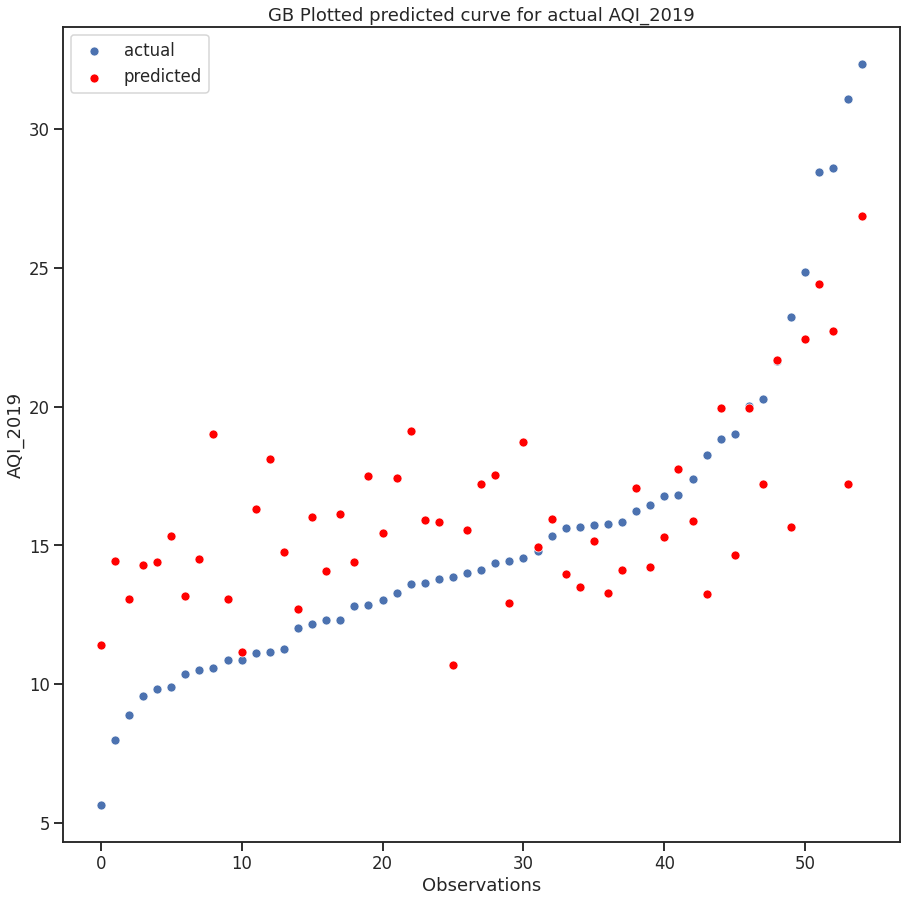

In [15]:
# plot linear regression
plt.figure(figsize=(15,15))
sns.scatterplot(data=y_test_sorted, x=np.arange(0,55), y='AQI_2019', label='actual')
sns.scatterplot(data=gb_y_pred, x=np.arange(0,55), y='AQI_2019', color='red', label='predicted')
# sns.lineplot(data=lr_y_pred, color='red', label='predicted')
# sns.lineplot(data=y_test_sorted, color='blue', label='actual')

plt.title('GB Plotted predicted curve for actual AQI_2019')
plt.xlabel('Observations')
plt.show();

### short transition to try out ada

In [20]:
ada_pipe = Pipeline([('scaler', StandardScaler()), ('ada', AdaBoostRegressor(random_state=42))])

In [21]:
ada_param_grid = {}

In [22]:
ada_grid = GridSearchCV(ada_pipe, ada_param_grid, cv=5)
ada_grid.fit(X_train, y_train)
ada_grid.best_score_, ada_grid.best_params_

(0.19012327181472838, {})

### plot lr, rf, and gb models comparisons


In [8]:
gb
lr = joblib.load('../../model/lr_model.sav')
rf = joblib.load('../../model/rf_best_feat_model.sav')



In [9]:
# 21 most important features
rf_feat_importances = ['HBAC_FEMALE_ratio_2017_2018_diff',
'NH_FEMALE_ratio_2018',
'HAA_MALE_ratio_2018_2019_diff',
'HWAC_MALE_ratio_2018',
'HAA_MALE_ratio_2017_2019_diff',
'BACH_TOT_2017_2019_diff',
'HWA_MALE_ratio_2018',
'HAA_MALE_2018_2019_diff',
'HBAC_FEMALE_ratio_2017_2019_diff',
'GRAD_TOT_ratio_2018',
'IAC_FEMALE_ratio_2017_2018_diff',
'NHIA_FEMALE_ratio_2017_2019_diff',
'HS_TOT_ratio_2017_2018_pct_change',
'NAC_FEMALE_2018_2019_diff',
'HS_TOT_2017_2018_pct_change',
'HAAC_MALE_ratio_2017_2018_diff',
'NH_FEMALE_ratio_2017_2019_pct_change',
'HWAC_FEMALE_ratio_2017_2019_pct_change',
'Personal income (thousands of dollars) 2018_2019_pct_change',
'HBA_FEMALE_ratio_2017_2018_pct_change',
'H_FEMALE_ratio_2017_2018_pct_change']

rf_important_feats_for_columns = rf_feat_importances
rf_important_feats_for_columns
X_train_rf_imp_feat = X_train[rf_important_feats_for_columns]
X_test_rf_imp_feat = X_test[rf_important_feats_for_columns]



In [10]:
lr_y_pred = lr.predict(X_test)
lr_y_pred = [item for sublist in lr_y_pred for item in sublist]
lr_y_pred = pd.DataFrame({'AQI_2019':lr_y_pred}, index=X_test.index)
lr_y_pred = lr_y_pred.reindex(index=y_test_sorted.index)
lr_y_pred[:10]

,AQI_2019
104,14.355138
55,14.509550
154,14.707381
100,14.149911
197,14.367638
164,15.100595
167,14.017142
203,14.740770
148,14.070864
120,14.268290


In [11]:
# plot random forest regressor
rf_y_pred = rf.predict(X_test_rf_imp_feat)
rf_y_pred = pd.DataFrame({'AQI_2019':rf_y_pred.tolist()}, index=y_test.index)
rf_y_pred = rf_y_pred.reindex(index=y_test_sorted.index)
rf_y_pred[:10]

,AQI_2019
104,12.866093
55,12.701301
154,14.096257
100,14.524487
197,15.184607
164,15.609487
167,14.214142
203,15.419348
148,16.036290
120,12.989433


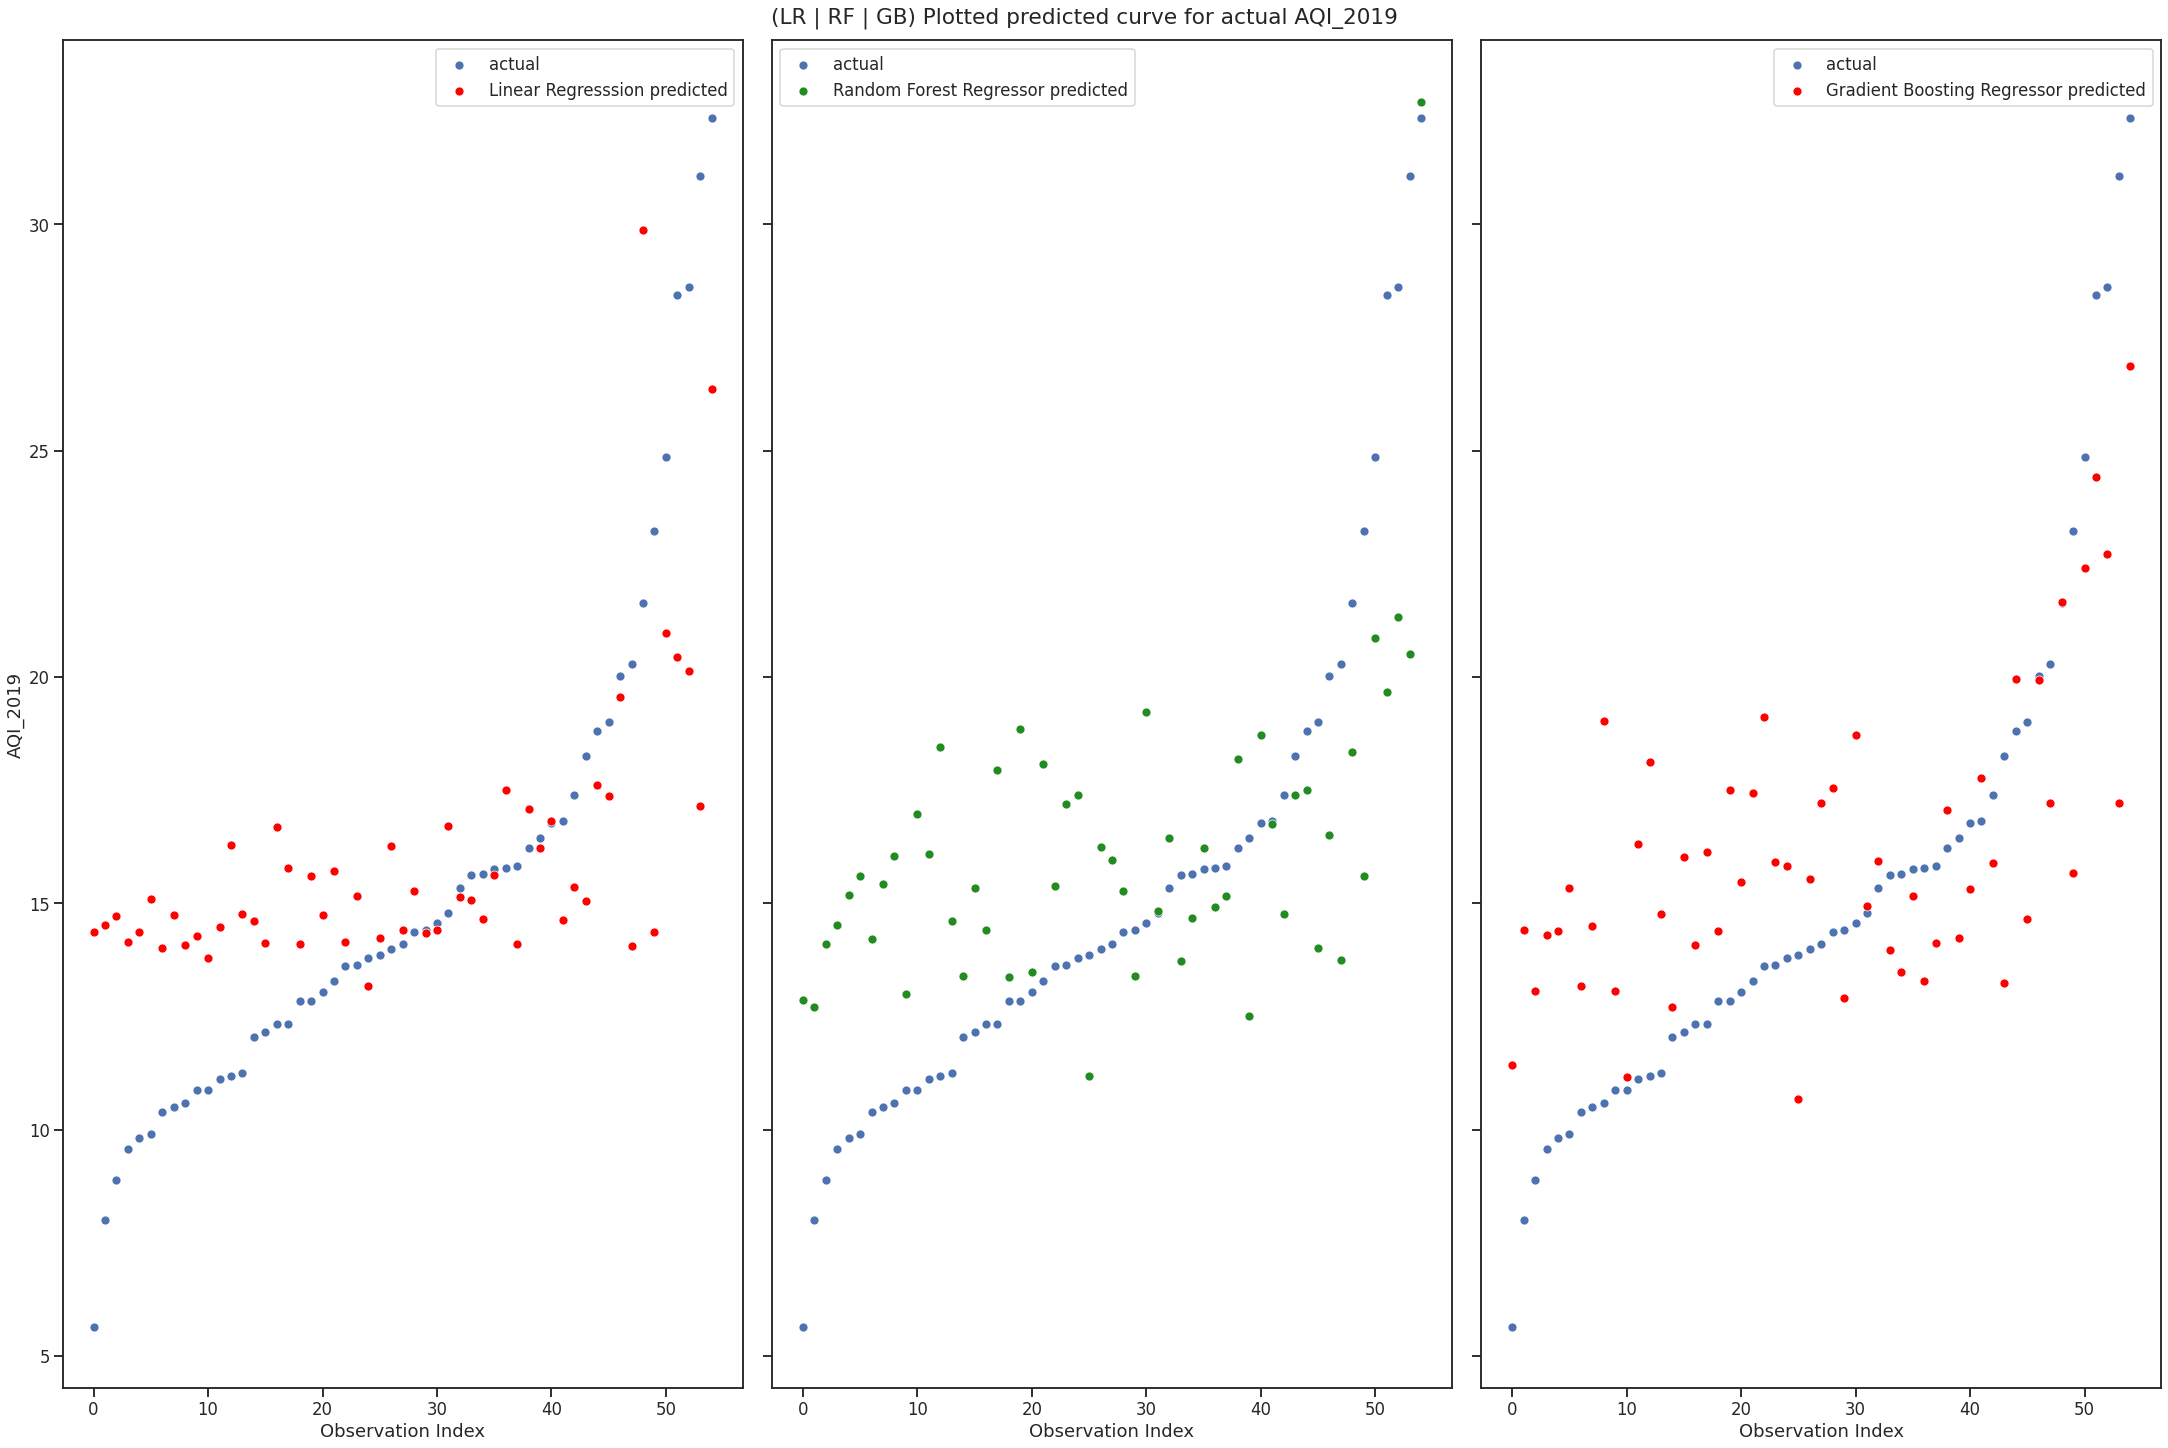

In [22]:
fig, ax = plt.subplots(1,3, figsize=(30,20), sharey=True, constrained_layout=True)
sns.scatterplot(data=y_test_sorted, x=np.arange(0,55), y='AQI_2019', label='actual', ax=ax[0])
sns.scatterplot(data=lr_y_pred, x=np.arange(0,55), y='AQI_2019', color='red', label='Linear Regresssion predicted', ax=ax[0])

sns.scatterplot(data=y_test_sorted, x=np.arange(0,55), y='AQI_2019', label='actual', ax=ax[1])
sns.scatterplot(data=rf_y_pred, x=np.arange(0,55), y='AQI_2019', color='forestgreen', label='Random Forest Regressor predicted', ax=ax[1])

sns.scatterplot(data=y_test_sorted, x=np.arange(0,55), y='AQI_2019', label='actual', ax=ax[2])
sns.scatterplot(data=gb_y_pred, x=np.arange(0,55), y='AQI_2019', color='red', label='Gradient Boosting Regressor predicted', ax=ax[2])
fig.suptitle('(LR | RF | GB) Plotted predicted curve for actual AQI_2019')
ax[0].set_xlabel('Observation Index')
ax[1].set_xlabel('Observation Index');
ax[2].set_xlabel('Observation Index');
